# Modellazione bayesiana {#sec-bayes-workflow}

![](../../figures/art_23.png){ width=40% }

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats
from scipy.stats import beta
from scipy.special import factorial
from scipy.special import comb
from scipy.integrate import quad

In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Introduzione {.unnumbered}

L'obiettivo di questo capitolo è introdurre il quadro concettuale della modellizzazione bayesiana. L'approccio bayesiano alla statistica si distingue non solo per l'uso del Teorema di Bayes, ma anche per il modo in cui gestisce l'incertezza e valuta l'intero spettro di possibili esiti attraverso le distribuzioni di probabilità. La modellazione bayesiana segue un approccio metodologico strutturato in diverse fasi: progettazione del modello, applicazione del teorema di Bayes e valutazione critica del modello. Questo flusso di lavoro bayesiano [@baribault2023troubleshooting] costituisce un ciclo di apprendimento e miglioramento continuo, in cui l'obiettivo non è trovare una "verità ultima" fissa e immutabile, ma aggiornare continuamente in modo razionale il grado di certezza attribuito alle ipotesi, sulla base delle nuove evidenze disponibili.

## Riesame del Teorema di Bayes

Prima di esplorare il flusso di lavoro bayesiano, è utile rivisitare il teorema di Bayes nelle sue diverse forme.

### Caso di Probabilità Discrete

Per eventi discreti osservabili, il teorema di Bayes si esprime come:

$$
P(H_i \mid O) = \frac{P(O \mid H_i) \cdot P(H_i)}{P(O)}
$$ 

dove:

- $P(H_i \mid O)$ è la probabilità dell'ipotesi $H_i$ data l'osservazione $O$,
- $P(O \mid H_i)$ è la probabilità dell'osservazione $O$ data l'ipotesi $H_i$,
- $P(H_i)$ è la probabilità a priori dell'ipotesi $H_i$,
- $P(O)$ è la probabilità marginale dell'osservazione $O$, calcolata come somma delle probabilità congiunte di tutte le ipotesi.

### Caso di Densità di Probabilità

In molte applicazioni statistiche, siamo interessati a stimare parametri continui basandoci su dati osservati. In questo contesto, passiamo dalla notazione per probabilità discrete a quella per distribuzioni di probabilità. Consideriamo un dato osservato $y$ e un parametro $\theta$. Il teorema di Bayes può essere riformulato come:

$$ 
p(\theta \mid y) = \frac{p(y \mid \theta) \cdot p(\theta)}{p(y)} 
$$ {#eq-bayes-cont2}

dove:

- $p(\cdot)$ rappresenta una funzione di densità di probabilità,
- $p(\theta \mid y)$ è la distribuzione posteriore del parametro $\theta$ alla luce dei dati $y$,
- $p(y \mid \theta)$ è la funzione di verosimiglianza,
- $p(\theta)$ è la distribuzione a priori del parametro $\theta$,
- $p(y)$ è la verosimiglianza marginale, calcolata come:

   $$ p(y) = \int p(y \mid \theta) p(\theta) \, d\theta .$$

L'@eq-bayes-cont2 può essere interpretata verbalmente come:

$$
\text{Posteriore} = \frac{\text{Verosimiglianza} \times \text{A Priori}}{\text{Verosimiglianza Marginale}}.
$$

Possiamo attribuire ai termini dell'@eq-bayes-cont2 il seguente significato.

1. **Posteriore** $p(\theta \mid y)$: È la distribuzione di probabilità del parametro $\theta$ condizionata ai dati osservati $y$. Rappresenta la nostra conoscenza aggiornata sul parametro dopo aver considerato i dati.
2. **Verosimiglianza** $p(y \mid \theta)$: Questa è la probabilità (o densità) dei dati osservati $y$, espressa come funzione del parametro $\theta$.
3. **A Priori** $p(\theta)$: È la distribuzione di probabilità iniziale del parametro $\theta$, prima di osservare i dati. Può basarsi su conoscenze pregresse o assumere forme non informative per minimizzare l'influenza sulle inferenze.
4. **Verosimiglianza Marginale** $p(y)$: Questo termine normalizza la distribuzione posteriore, assicurando che integri a 1 e sia quindi una distribuzione di probabilità valida.


## Applicazioni dell'Aggiornamento Bayesiano 

Per spiegare il concetto di aggiornamento bayesiano in maniera intuitiva, McElreath propone il seguente esempio. Supponiamo di avere un globo terrestre e di volere stimare qual è la proporzione della superficie terrestre coperta d'acqua. Per stimare questa proporzione eseguiamo il seguente esperimento casuale: lanciamo in aria il globo e poi lo afferriamo quando cade. Registriamo se la superficie sotto il nostro indice destro è terra o acqua. Ripetiamo questa procedura un certo numero di volte e calcoliamo la proporzione di volte in cui abbiamo osservato "acqua". In ogni lancio, ogni valore della proporzione sconosciuta $p$ può essere più o meno probabile, date le evidenze fornite dai lanci precedenti.

Un modello bayesiano inizia assegnando un insieme di probabilità iniziali a ciascuno dei possibili valori $p$, dette probabilità a priori. Poi, queste probabilità vengono aggiornate alla luce dei dati raccolti, producendo le probabilità a posteriori. Questo processo di aggiornamento è una forma di apprendimento, conosciuto come aggiornamento bayesiano.

Nell'esempio di McElreath, supponiamo che il nostro modello bayesiano assegni inizialmente la stessa probabilità a ogni possibile valore di $p$ (proporzione di acqua). Ora, consideriamo il primo grafico in alto a sinistra nella figura.

La linea tratteggiata orizzontale rappresenta la distribuzione di probabilità a priori per ciascun possibile valore di $p$. Dopo aver osservato il primo lancio, che risulta in "W" (acqua), il modello aggiorna le probabilità di $p$ alla linea continua. La probabilità che $p$ = 0 scende a zero, indicando che è impossibile non avere acqua, dato che abbiamo osservato almeno una traccia di acqua sul globo. Allo stesso modo, la probabilità che $p$ > 0.5 aumenta, poiché non c'è ancora evidenza di terra sul globo, quindi le probabilità a priori vengono modificate per essere coerenti con questa osservazione. Tuttavia, le differenze nelle probabilità non sono ancora molto grandi, poiché le evidenze raccolte finora sono limitate. In questo modo, la quantità di evidenza vista finora si riflette nelle probabilità di ciascun valore di $p$: la probabilità che $p$ sia 0 è zero e la probabilità che $p$ sia 1 è massima. Quindi, la distribuzione a posteriori di $p$ è rappresentata dalla linea continua che collega questi due estremi.

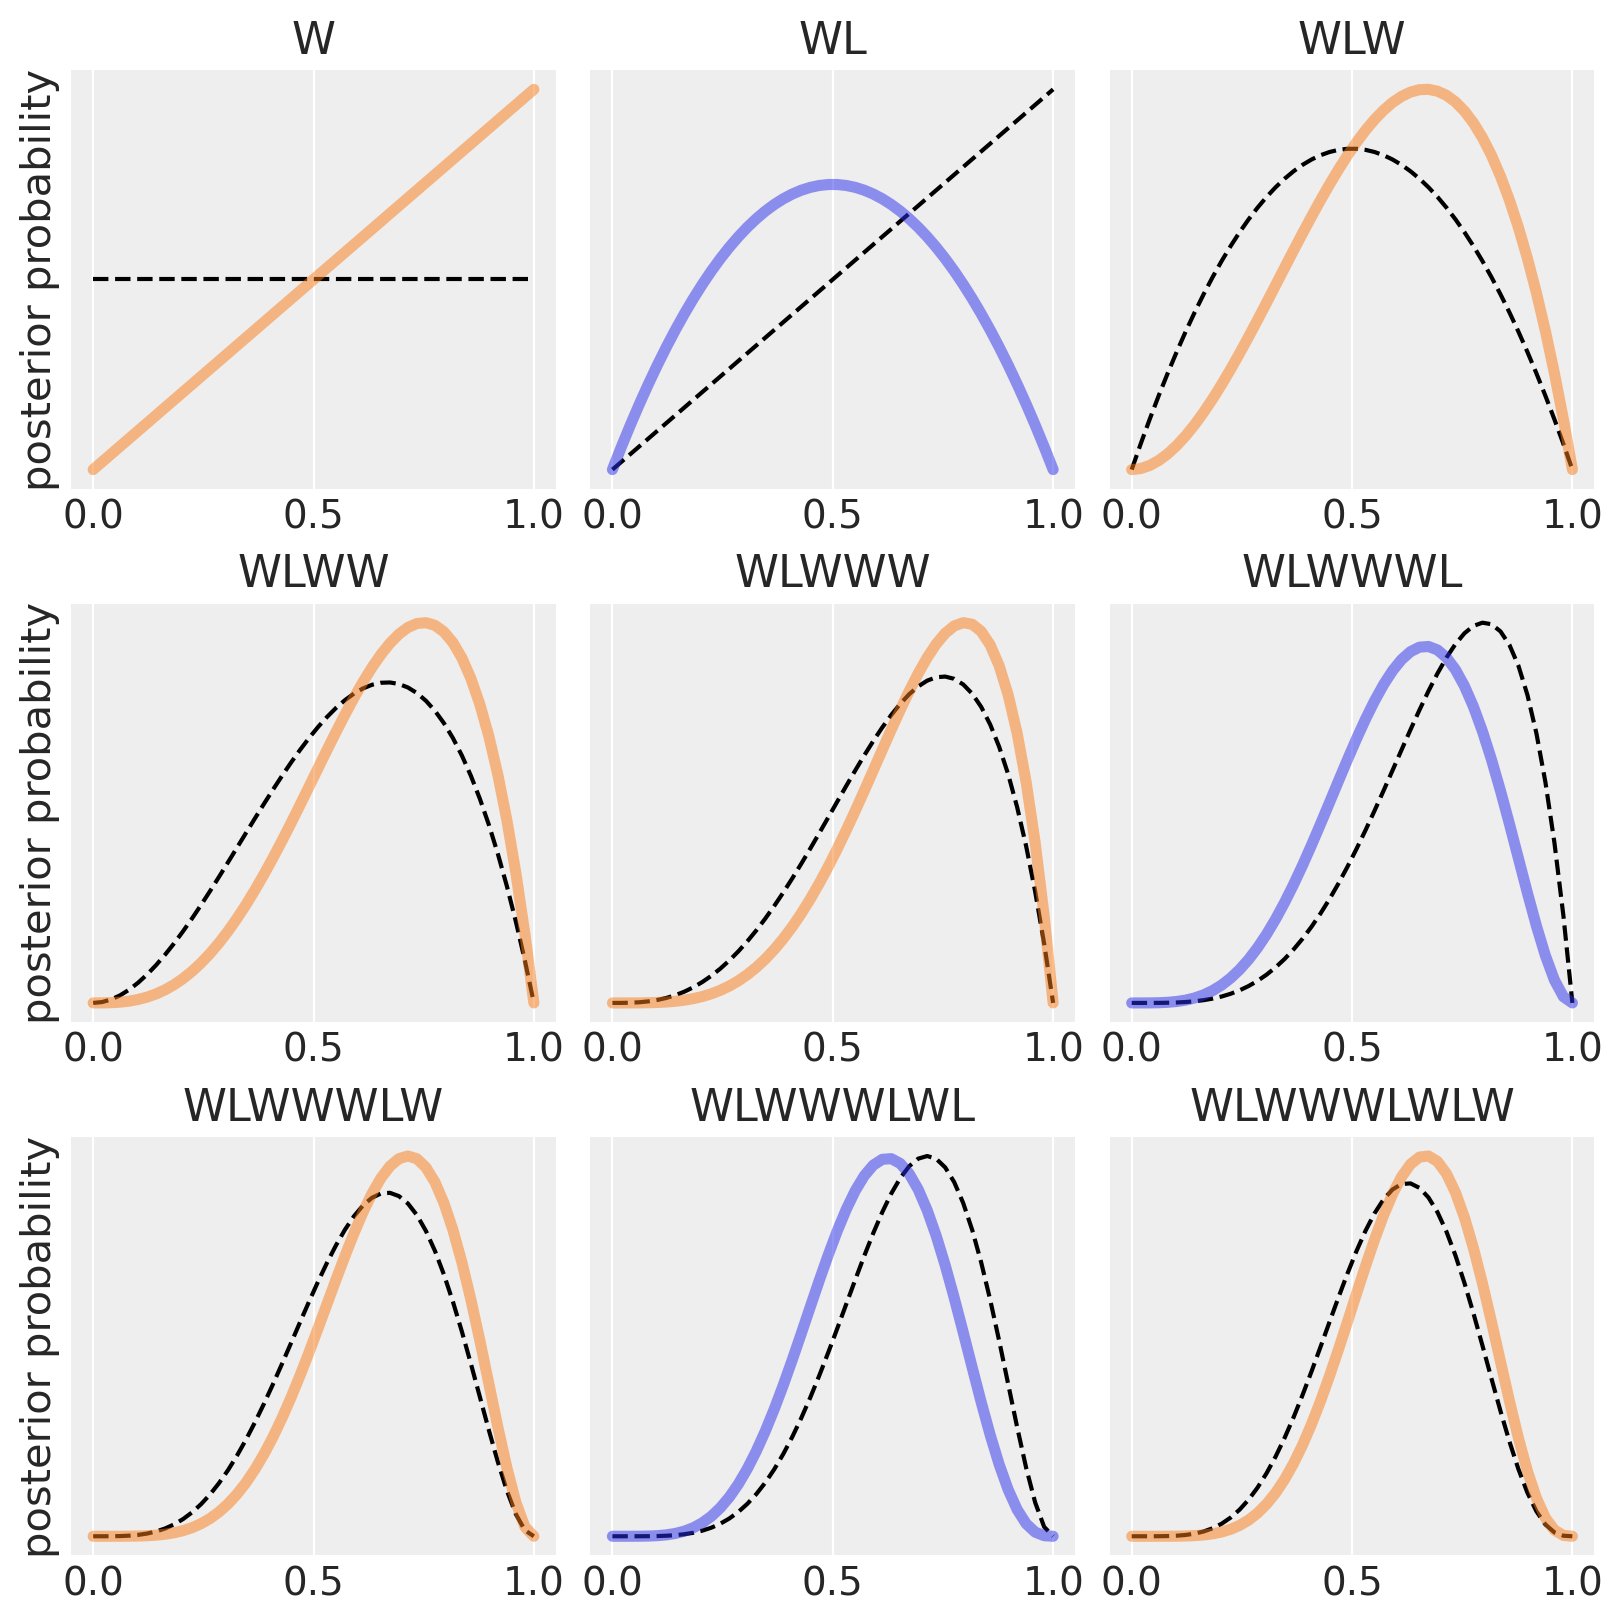

In [3]:
def beta(W, L, p):
    return factorial(W + L + 1) / (factorial(W) * factorial(L)) * p ** W * (1-p) ** L


def plot_beta_from_observations(observations: str, resolution: int = 50, **plot_kwargs):
    """Calcualte the posterior for a string of observations"""
    n_W = len(observations.replace("L", ""))
    n_L = len(observations) - n_W
    proportions = np.linspace(0, 1, resolution)
        
    probs = beta(n_W, n_L, proportions)
    plt.plot(proportions, probs, **plot_kwargs)
    plt.yticks([])
    plt.title(observations)
    

# Tossing the globe
observations = "WLWWWLWLW"
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for ii in range(9):
    ax = axs[ii // 3][ii % 3]
    plt.sca(ax)
    # Plot previous
    if ii > 0:
        plot_beta_from_observations(observations[:ii], color='k', linestyle='--')
    else:
        # First observation, no previous data
        plot_beta_from_observations('', color='k', linestyle='--')
        
    color = 'C1' if observations[ii] == 'W' else 'C0'
    plot_beta_from_observations(observations[:ii+1], color=color, linewidth=4, alpha=.5)
    
    if not ii % 3:
        plt.ylabel("posterior probability")

**Correzione e miglioramento del testo**

Nei grafici successivi, vengono introdotti ulteriori campioni dal globo, uno alla volta. Ogni curva tratteggiata rappresenta la curva continua dal grafico precedente, spostandosi da sinistra a destra e dall'alto in basso.

La seconda osservazione è "terra" (L). La distribuzione a priori è la linea tratteggiata del secondo pannello, mentre la distribuzione a posteriori è la linea curva. Otteniamo questa curva poiché assegniamo una probabilità pari a 0 agli eventi $p$ = 0 (abbiamo osservato "acqua") e $p$ = 1 (abbiamo osservato "terra"). In due lanci, abbiamo osservato una volta "terra" e una volta "acqua". Pertanto, la probabilità che $p$ = 0.5 è massima, da cui deriva la curva che abbiamo disegnato.

Il terzo lancio del globo produce nuovamente "acqua". A questo punto, il valore più probabile di $p$ è 0.75. Modifichiamo dunque la distribuzione a priori (linea tratteggiata nel terzo pannello) in modo da rappresentare le nostre nuove conoscenze, come indicato dalla linea continua.

Ogni volta che viene osservata "acqua" (W), il picco della curva di probabilità si sposta a destra, verso valori maggiori di $p$. Ogni volta che viene osservata "terra" (L), si sposta nella direzione opposta. L'altezza massima della curva aumenta con ogni campione, indicando che la probabilità complessiva (1) viene ridistribuita su un numero minore di valori di $p$, i quali accumulano una maggiore probabilità man mano che cresce la quantità di evidenze. Con l'aggiunta di ogni nuova osservazione, la curva viene aggiornata in modo coerente con tutte le osservazioni precedenti.

È importante notare che ogni insieme aggiornato di probabilità diventa la probabilità iniziale per l'osservazione successiva. Ogni conclusione è il punto di partenza per l'inferenza futura. Questo processo di aggiornamento funziona anche al contrario: conoscendo l'ultimo set di probabilità e l'ultima osservazione, è possibile matematicamente dedurre la curva di probabilità precedente. I dati possono essere presentati al modello in qualsiasi ordine, o anche tutti insieme. Di solito, i dati vengono considerati tutti insieme per comodità, ma è importante capire che ciò rappresenta solo una semplificazione di un processo di apprendimento iterativo.

Questo esempio illustra come la funzione di probabilità a posteriori si modifichi progressivamente con l'acquisizione di nuove evidenze. Tale processo avviene automaticamente, riflettendo il meccanismo di aggiornamento delle credenze che caratterizza l'inferenza bayesiana. In ogni pannello, la transizione dalla linea tratteggiata alla linea piena simboleggia questo aggiornamento: la linea tratteggiata rappresenta la distribuzione di probabilità a priori, ovvero le nostre credenze iniziali prima dell'osservazione dei nuovi dati; la linea piena, invece, rappresenta la distribuzione di probabilità a posteriori, che integra le nuove evidenze ai preconcetti iniziali. Quest'ultima rispecchia dunque una sintesi ottimizzata delle informazioni pregresse e attuali, offrendo una rappresentazione aggiornata e più accurata della realtà in esame.

In questo specifico esempio, la distribuzione a priori del parametro $p$ è la distribuzione uniforme indicata dalla linea tratteggiata del primo pannello. I dati sono costituiti dall'osservazione di 6 successi in 9 prove. La distribuzione a posteriori $p(\theta \mid y)$ è rappresentata dalla funzione continua presente nell'ultimo pannello. L'aggiornamento bayesiano è il passaggio dalla funzione a priori uniforme $p(\theta)$ alla funzione a posteriori $p(\theta \mid y)$. La moda della funzione $p(\theta \mid y)$ ci indica il valore più verosimile di $\theta$ (proporzione di acqua sul globo terrestre) dopo aver osservato 6 successi in 9 prove del nostro esperimento casuale (lancio del mappamondo).

## Il Processo Generatore dei Dati

Nel processo di aggiornamento bayesiano, il ricercatore deve fare un'assunzione sul modello statistico che governa la produzione dei dati osservati. Questo modello statistico si chiama "processo generatore dei dati". Nel caso presente, è facile capire qual è il modello generatore dei dati. I nostri dati corrispondono a una sequenza di prove bernoulliane indipendenti, generate da un processo in cui possiamo assumere che la probabilità di successo, ovvero la probabilità di osservare "acqua", resta costante nella sequenza di prove. Questo è giustificato dal fatto che le caratteristiche del mappamondo (ovvero la distribuzione spaziale di acqua e terra) restano costanti. In tali circostanze, il modello statistico all'origine dei dati osservati è il modello binomiale. Tenuto costante il numero di prove, il modello binomiale dipende da un solo parametro: la probabilità di successo $\theta$ (nel caso presente, la proporzione di acqua sul globo terrestre).

L'aggiornamento bayesiano riguarda dunque le nostre credenze rispetto a $\theta$. In questo esempio, siamo passati da una situazione in cui non avevamo informazioni su $\theta$, rappresentata da una distribuzione uniforme in cui tutti i valori di $\theta$ nell'intervallo unitario [0, 1] erano ugualmente possibili, a una situazione in cui, avendo osservato 6 successi in 9 prove e applicato il teorema di Bayes, le nostre credenze su $\theta$ sono rappresentate dalla curva continua nell'ultimo pannello. La moda (o la media, o la mediana) di tale funzione rappresenta il valore più verosimile di $\theta$, avendo osservato i dati e integrato tali informazioni con le nostre credenze a priori. L'incertezza della nostra credenza a posteriori è rappresentata dall'ampiezza della distribuzione di $p(\theta \mid y)$. Se la massa di $p(\theta \mid y)$ si distribuisce su un intervallo ampio del supporto di $\theta$, significa che la nostra incertezza a posteriori è grande; al contrario, se la massa di $p(\theta \mid y)$ si distribuisce su un intervallo molto piccolo del supporto di $\theta$, possiamo concludere che abbiamo poca incertezza su quale sia il vero valore di $\theta$.

In questo esempio abbiamo visto come integrare una distribuzione uniforme con i dati costituiti da $y$ successi in $N$ prove bernoulliane. Nel capitolo @sec-subj-prop vedremo in maniera più dettagliata come si produce l'aggiornamento bayesiano nel caso di distribuzioni a priori discrete o continue, uniformi o non uniformi.

## Notazione

La costruzione di modelli statistici bayesiani, che utilizzano un approccio probabilistico per caratterizzare l'incertezza, richiede una conoscenza preliminare del linguaggio e delle notazioni matematiche impiegate in questi modelli. Questa comprensione facilita la comunicazione delle caratteristiche del modello e permette di estendere il linguaggio di modellazione a diversi domini.

In seguito, utilizzeremo $y$ per rappresentare i dati osservati e $\theta$ per indicare i parametri sconosciuti di un modello statistico. Entrambi, $y$ e $\theta$, saranno trattati come variabili casuali. Utilizzeremo $x$ per denotare le quantità note, come i predittori di un modello lineare.

Per rappresentare i modelli probabilistici (ovvero, i modelli generatori dei dati) in modo più conciso, adotteremo una notazione specifica. Ad esempio, invece di scrivere la distribuzione di probabilità di $\theta$ come $p(\theta) = Beta(1, 1)$, scriveremo semplicemente $\theta \sim Beta(1, 1)$. Il simbolo "$\sim$" si legge come "segue la distribuzione di". Possiamo anche interpretarlo nel senso che $\theta$ è un campione casuale estratto dalla distribuzione Beta(1, 1). Analogamente, la verosimiglianza di un modello binomiale sarà espressa come $y \sim \text{Bin}(n, \theta)$, dove "$\sim$" indica che $y$ segue una distribuzione binomiale con parametri $n$ e $\theta$. Questa notazione semplifica la rappresentazione dei modelli probabilistici, rendendo più chiara la relazione tra i dati, i parametri e le distribuzioni di probabilità coinvolte nelle analisi statistiche.

## Metodi di Stima della Distribuzione a Posteriori

Nella modellizzazione bayesiana, $\theta$ è solitamente una variabile casuale continua. In tali circostanze, la distribuzione posteriore si formula come segue:

$$
p(\theta \mid y) = \frac{p(y \mid \theta) \cdot p(\theta)}{\int_{\Theta} p(y \mid \theta) \cdot p(\theta) \, d\theta}, \quad \text{dove} \quad \theta \in \Theta,
$$

dove $\Theta$ denota l'insieme di tutti i possibili valori del parametro $\theta$.

Il calcolo di $p(\theta \mid y)$ richiede la normalizzazione del prodotto tra la funzione di verosimiglianza $p(y \mid \theta)$ e la distribuzione a priori $p(\theta)$ attraverso una costante di normalizzazione. Questa costante, nota come verosimiglianza marginale, assicura che l'integrale di $p(\theta \mid y)$ su tutto lo spazio dei parametri $\Theta$ sia pari a uno.

### Esempio di Calcolo della Verosimiglianza Marginale

Consideriamo una variabile casuale binomiale $Y$ con funzione di massa di probabilità (PMF) $p(Y)$ in relazione a un parametro $\theta$. Supponiamo che $\theta$ possa assumere uno di tre valori specifici: 0.1, 0.5 o 0.9, ciascuno con probabilità $\frac{1}{3}$.

Fissiamo i dati a $n = 10$ prove e $k = 7$ successi, ottenendo la seguente funzione di likelihood:

$$
p(k = 7, n = 10 | \theta) = \binom{10}{7} \theta^7 (1 - \theta)^3.
$$

Per calcolare la verosimiglianza marginale $p(k = 7, n = 10)$, marginalizziamo il parametro $\theta$ valutando la likelihood per ciascun valore possibile di $\theta$, moltiplicandola per la probabilità di quel valore di $\theta$ e sommando i risultati ottenuti:

$$
p(k = 7, n = 10) = \sum_{i=1}^{3} p(k = 7, n = 10 | \theta_i) \cdot p(\theta_i).
$$

Sostituendo i valori di $\theta$ e la loro probabilità:

$$
p(k = 7, n = 10) = \frac{1}{3} \binom{10}{7} 0.1^7 (1 - 0.1)^3 + \frac{1}{3} \binom{10}{7} 0.5^7 (1 - 0.5)^3 + \frac{1}{3} \binom{10}{7} 0.9^7 (1 - 0.9)^3.
$$

Questo processo mostra come la marginalizzazione incorpori tutte le possibili variazioni di $\theta$, ottenendo una misura complessiva che considera l'incertezza su $\theta$. 

### Implementazione in Python

Per implementare questo calcolo in Python, possiamo definire una funzione che calcoli la likelihood per i valori discreti di $\theta$ e poi sommare i risultati. Per l'integrazione su un intervallo continuo, possiamo utilizzare la libreria `scipy`.

In [5]:
# Funzione di likelihood
def likelihood(theta, k=7, n=10):
    return comb(n, k) * (theta**k) * ((1 - theta)**(n - k))

# Likelihood marginale per valori discreti di theta
theta_vals = np.array([0.1, 0.5, 0.9])
prob_theta = 1/3
marginal_likelihood_discrete = sum([likelihood(theta) * prob_theta for theta in theta_vals])

print(f"Likelihood Marginale (discreta): {marginal_likelihood_discrete}")

# Likelihood marginale su un intervallo continuo [0, 1]
marginal_likelihood_continuous, _ = quad(lambda theta: likelihood(theta), 0, 1)

print(f"Likelihood Marginale (continua): {marginal_likelihood_continuous}")

Likelihood Marginale (discreta): 0.05819729199999999
Likelihood Marginale (continua): 0.09090909090909091


### Metodi per Determinare la Distribuzione a Posteriori

Esistono due approcci principali per determinare la distribuzione posteriore:

1. **Approccio Analitico**: Questo metodo si applica quando la distribuzione a priori e la funzione di verosimiglianza appartengono alla stessa famiglia di distribuzioni, dette *coniugate*. In questi casi, è possibile calcolare analiticamente la distribuzione posteriore. Questo approccio è efficiente ma limitato alle situazioni con coniugazione tra distribuzioni a priori e funzioni di verosimiglianza.
   
2. **Approccio Numerico**: Quando l'approccio analitico non è applicabile, si usano tecniche di approssimazione numerica. Le catene di Markov Monte Carlo (MCMC) sono spesso impiegate per stimare numericamente la distribuzione posteriore. Questo metodo è versatile ma richiede un maggiore impegno computazionale.

### Linguaggi di Programmazione Probabilistici

L'uso di tecniche di approssimazione numerica per stimare le distribuzioni posteriori è facilitato dai linguaggi di programmazione probabilistica (PPL). Questi strumenti rendono la modellazione bayesiana più accessibile, riducendo le barriere di competenza matematica e computazionale. I PPL permettono agli analisti di formulare modelli probabilistici con maggiore chiarezza e flessibilità, aprendo nuovi orizzonti nell'analisi bayesiana e permettendo di affrontare problemi complessi con tecniche bayesiane avanzate.

## Commenti e considerazioni finali 

Nell'ambito dell'inferenza statistica, i metodi bayesiani stanno guadagnando una crescente popolarità anche in psicologia. Questa tendenza è sostenuta dalla disponibilità di risorse educative e pubblicazioni specializzate che facilitano l'integrazione dei metodi bayesiani nella pratica analitica. Opere come quelle di @albert_2019prob, @Johnson2022bayesrules, @McElreath_rethinking e @doingbayesian hanno svolto un ruolo cruciale in questo contesto, rendendo accessibili e comprensibili i concetti fondamentali della modellizzazione bayesiana.

L'approccio bayesiano offre una prospettiva unica sull'incertezza associata ai parametri di interesse, differenziandosi dalla metodologia frequentista basata sul test dell'ipotesi nulla. Mentre il paradigma frequentista considera i parametri come valori fissi e sconosciuti, l'approccio bayesiano li tratta come quantità probabilistiche, assegnando loro una distribuzione a priori che riflette le credenze iniziali. Attraverso il teorema di Bayes, queste credenze vengono aggiornate sulla base dei dati osservati, portando alla definizione della distribuzione a posteriori. Questa distribuzione fornisce una visione aggiornata dell'incertezza, integrando sia l'evidenza empirica che le informazioni pregresse.

La forza dell'approccio bayesiano risiede nella sua capacità di combinare conoscenze pregresse con nuove osservazioni, producendo stime dei parametri di interesse che sono non solo più accurate ma anche più significative dal punto di vista interpretativo. Più di un semplice strumento statistico, il bayesianesimo si rivela un potente mezzo decisionale, promuovendo un'interazione dinamica tra teoria ed esperienza.

Tuttavia, uno svantaggio dell'approccio bayesiano è la sua potenziale inefficienza nel trattare dataset molto estesi. Questo può comportare problemi di scalabilità e di efficienza computazionale, soprattutto con insiemi di dati di grandi dimensioni. Per affrontare questa sfida, sono in sviluppo metodi di *variational inference*, che offrono un'alternativa al campionamento MCMC. Questi metodi approssimativi permettono di calcolare la distribuzione a posteriori in tempi significativamente ridotti, migliorando l'efficienza computazionale senza sacrificare troppo la precisione delle stime.

In conclusione, l'approccio bayesiano rappresenta un paradigma potente e flessibile per l'inferenza statistica, in grado di incorporare le conoscenze pregresse e aggiornarsi alla luce di nuove evidenze. Nonostante le sfide computazionali, i progressi nei metodi approssimativi come la variational inference promettono di rendere l'analisi bayesiana sempre più praticabile ed efficace, estendendo ulteriormente il suo utilizzo in campi come la psicologia e oltre.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Aug 05 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.9.1
scipy     : 1.14.0
arviz     : 0.18.0
numpy     : 1.26.4

Watermark: 2.4.3

